In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import collections
from datetime import datetime

df = pd.read_csv("dataset/complaint_data.csv")
df_col_desc = pd.read_csv("dataset/column_desc.csv")

# Data cleansing - removing null columns and data points

dropcols = ["Lat_Lon","X_COORD_CD","Y_COORD_CD","CMPLNT_NUM"] # Redundant columns
for i in df.columns:
    if float(df[i].isnull().sum())/len(df)*100 > 20: # if more than 10% data is empty, clip the column
        dropcols.append(i)
df = df.drop(dropcols, axis=1)
df = df[~df.isnull().any(axis=1)]

# Parsing the DateTime column 

df["RPT_DT"] = df["RPT_DT"].apply(lambda x: datetime.strptime(x, '%m/%d/%y')
                                  .strftime('%Y-%m-%d')).astype('datetime64[ns]')
df["CMPLNT_FR_DT"] = df["CMPLNT_FR_DT"].apply(lambda x: datetime.strptime(x, '%m/%d/%y')
                                              .strftime('%Y-%m-%d')).astype('datetime64[ns]')
df["CMPLNT_TO_DT"] = df["CMPLNT_TO_DT"].apply(lambda x: datetime.strptime(x, '%m/%d/%y')
                                              .strftime('%Y-%m-%d')).astype('datetime64[ns]')

df["RPT_DT"] = pd.to_datetime(df["RPT_DT"])
df["CMPLNT_FR_DT"] = pd.to_datetime(df["CMPLNT_FR_DT"])
df["CMPLNT_TO_DT"] = pd.to_datetime(df["CMPLNT_TO_DT"])

df["FR_TM_CAT"] = df["CMPLNT_FR_TM"].apply(lambda x: int(x.strip().split(':')[0])//6)
df["FR_TM_CAT"] = df["CMPLNT_TO_TM"].apply(lambda x: int(x.strip().split(':')[0])//6)

# Removing outliers

df = df[~(df['CMPLNT_TO_DT'] >= '2017-01-01')]

In [4]:
# Compiling list of Offenses, their categories and key codes

offense_code = {}
offlist = df["OFNS_DESC"].unique()
for each in offlist:
    key = df[df["OFNS_DESC"]==each]["KY_CD"].unique()[0]
    offense_code[key] = each

print "Offense Codes and Description " + str(len(offense_code))
print ""
offense_code = collections.OrderedDict(sorted(offense_code.items()))
for k,v in offense_code.items():
    print k,v
    
# Repeating the same for Police Codes and Descriptions

pd_code = {}
pdlist = df["PD_DESC"].unique()
for each in pdlist:
    key = df[df["PD_DESC"]==each]["PD_CD"].unique()[0]
    pd_code[key] = each

print ""
print "Police Department Codes and Descriptions " + str(len(pd_code))
pd_code = collections.OrderedDict(sorted(pd_code.items()))
for k,v in pd_code.items():
    print k,v

# INFERENCES

# Using only KY_CD, PD_CD for analysis

#df = df.drop(['PD_DESC','OFNS_DESC'], axis=1)

Offense Codes and Description 54

102 HOMICIDE-NEGLIGENT-VEHICLE
103 HOMICIDE-NEGLIGENT,UNCLASSIFIE
105 ROBBERY
106 FELONY ASSAULT
107 BURGLARY
109 GRAND LARCENY
110 GRAND LARCENY OF MOTOR VEHICLE
111 POSSESSION OF STOLEN PROPERTY
112 THEFT-FRAUD
113 FORGERY
114 ARSON
118 DANGEROUS WEAPONS
119 INTOXICATED/IMPAIRED DRIVING
120 ENDAN WELFARE INCOMP
124 KIDNAPPING
125 NYS LAWS-UNCLASSIFIED FELONY
126 MISCELLANEOUS PENAL LAW
230 JOSTLING
231 BURGLAR'S TOOLS
233 SEX CRIMES
235 DANGEROUS DRUGS
237 ESCAPE 3
238 FRAUDULENT ACCOSTING
340 FRAUDS
341 PETIT LARCENY
342 PETIT LARCENY OF MOTOR VEHICLE
343 THEFT OF SERVICES
344 ASSAULT 3 & RELATED OFFENSES
345 OFFENSES RELATED TO CHILDREN
346 ALCOHOLIC BEVERAGE CONTROL LAW
347 INTOXICATED & IMPAIRED DRIVING
348 VEHICLE AND TRAFFIC LAWS
349 DISRUPTION OF A RELIGIOUS SERV
350 GAMBLING
351 CRIMINAL MISCHIEF & RELATED OF
352 CRIMINAL TRESPASS
353 UNAUTHORIZED USE OF A VEHICLE
354 ANTICIPATORY OFFENSES
355 OFFENSES AGAINST THE PERSON
356 PROSTITUTION & RE

In [2]:
# NOTES

# CRM_ATPT_CPTD_CD - Generate Category variable (Successful, Failed, Attempted)
# Types of Crime across Zipcodes - Start with LAW_CAT_CD
# Precinct involved - look for patterns across this
# Categorical variables include - CRM_ATPT_CPTD_CD, KY_CD, PD_CD, LAW_CAT_CD, ADDR_PCT_CD, 
#                                 BORO_NM, PREM_TYP_DESC, ZIPCODE
# Numerical variables - Latitude, Longitude
# TRY - KMODES clustering for mixed data
# Check diff in dates of crime committed and reported
# Drop columns PD_CD, PD_DESC, OFNS_DESC
# Duration of crimes - 'CMPLNT_FR_TM','CMPLNT_TO_TM'

In [5]:
# MACHINE LEARNING - GENERATING CATEGORY VARIABLES

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['CRM_ATPT_CPTD_CD'])
df['CRM_CAT'] = le.transform(df['CRM_ATPT_CPTD_CD'])

le = preprocessing.LabelEncoder()
le.fit(df['LAW_CAT_CD'])
df['LAW_CAT'] = le.transform(df['LAW_CAT_CD'])

le = preprocessing.LabelEncoder()
le.fit(df['JURIS_DESC'])
df['JURIS_CAT'] = le.transform(df['JURIS_DESC'])

le = preprocessing.LabelEncoder()
le.fit(df['BORO_NM'])
df['BORO_CAT'] = le.transform(df['BORO_NM'])

le = preprocessing.LabelEncoder()
le.fit(df['PREM_TYP_DESC'])
df['PREM_CAT'] = le.transform(df['PREM_TYP_DESC'])

df['DATE_CAT'] = df['CMPLNT_FR_DT'].map(lambda x: x.month)
df = df.reset_index(drop=True)

In [6]:
# K-Means Clustering Algorithm
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

# KMeans Algorithm

from sklearn.cluster import KMeans
def clustering(train, usecols, n):
    #kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    kproto = KPrototypes(n_clusters=n, init='Cao', verbose=2)
    kproto.fit_predict(train, categorical=usecols)
    return kproto.cluster_centroids_, kproto.labels_

cols = ["FR_TM_CAT","DATE_CAT","KY_CD","CRM_CAT","LAW_CAT","BORO_CAT","ADDR_PCT_CD",
        "PREM_CAT","Latitude","Longitude"]
cat = [0,1,2,3,4,5,6,7] # as first n columns are categorical
num_clusters = 3
centers, labels = clustering(df[cols].as_matrix(),cat,num_clusters)
print centers

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 56530, ncost: 64529186.7634
Run: 1, iteration: 2/100, moves: 3376, ncost: 64529186.2392
Run: 1, iteration: 3/100, moves: 334, ncost: 64529186.2313
Run: 1, iteration: 4/100, moves: 45, ncost: 64529186.2311


KeyboardInterrupt: 

In [ ]:
# K-Means Clustering Algorithm
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

# KMeans Algorithm

from sklearn.cluster import KMeans
def clustering(train, usecols, n):
    #kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    kproto = KPrototypes(n_clusters=n, init='Cao', verbose=2)
    kproto.fit_predict(train, categorical=usecols)
    return kproto.cluster_centroids_, kproto.labels_

cols = ["FR_TM_CAT","DATE_CAT","KY_CD","CRM_CAT","LAW_CAT","BORO_CAT","ADDR_PCT_CD",
        "PREM_CAT","Latitude","Longitude"]
cat = [0,1,2,3,4,5,6,7] # as first n columns are categorical
num_clusters = 2
centers2, labels22 = clustering(df[cols].as_matrix(),cat,num_clusters)
print centers2

In [23]:
# K-Means Clustering Algorithm
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

# KMeans Algorithm

from sklearn.cluster import KMeans
def clustering(train, usecols, n):
    #kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    kproto = KPrototypes(n_clusters=n, init='Cao', verbose=2)
    kproto.fit_predict(train, categorical=usecols)
    return kproto.cluster_centroids_, kproto.labels_

cols = ["FR_TM_CAT","DATE_CAT","KY_CD","CRM_CAT","LAW_CAT","BORO_CAT","ADDR_PCT_CD",
        "PREM_CAT","Latitude","Longitude"]
cat = [0,1,2,3,4,5,6,7] # as first n columns are categorical
num_clusters = 4
centers4, labels4 = clustering(df[cols].as_matrix(),cat,num_clusters)
print centers4

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 115090, ncost: 62085656.4878
Run: 1, iteration: 2/100, moves: 28809, ncost: 62085639.2394
Run: 1, iteration: 3/100, moves: 532, ncost: 62085639.2349
Run: 1, iteration: 4/100, moves: 3, ncost: 62085639.2349
Run: 1, iteration: 5/100, moves: 0, ncost: 62085639.2349
[array([[ 40.68276435, -73.95243167],
       [ 40.74250527, -73.95166624],
       [ 40.72073885, -73.87293915],
       [ 40.81208904, -73.90180966]]), array([[   2.,   10.,  341.,    1.,    1.,    1.,   75.,   58.],
       [   3.,    9.,  109.,    1.,    0.,    2.,   14.,   49.],
       [   1.,   11.,  344.,    1.,    1.,    3.,  114.,   49.],
       [   3.,   12.,  351.,    1.,    1.,    0.,   47.,   58.]])]


In [8]:
# K-Means Clustering Algorithm
from sklearn.neighbors import NearestNeighbors
from kmodes.kprototypes import KPrototypes

# KMeans Algorithm

from sklearn.cluster import KMeans
def clustering(train, usecols, n):
    #kmeans = KMeans(n_clusters=n, random_state=0,).fit(train)
    kproto = KPrototypes(n_clusters=n, init='Cao', verbose=2)
    kproto.fit_predict(train, categorical=usecols)
    return kproto.cluster_centroids_, kproto.labels_

cols = ["CRM_CAT","ADDR_PCT_CD"]
cat = [0,2] # as first n columns are categorical
num_clusters = 2
centers5, labels5 = clustering(df[cols].as_matrix(),cat,num_clusters)
print centers5

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 1.55730820982e+11
[array([[    83.        ],
       [ 10782.39339821]]), array([['COMPLETED', '22'],
       ['COMPLETED', '75']],
      dtype='|S21')]


In [ ]:
df['labels'] = labels
print df['labels'].value_counts()

# 1. Plot number of crimes vs clusters
# 2. Plot lat-long for every clusters and compare
# 3. Plot number of crimes foiled (%) vs clusters
# 4. Plot category of crimes for every clusters
# 5. Plot category of premises for every clusters

In [ ]:
df['labels'].value_counts()

In [9]:
cluster0 = df[df['labels']==0]
cluster1 = df[df['labels']==1]
cluster2 = df[df['labels']==2]

In [8]:
df = pd.read_csv("dataset/complaint_data.csv")

In [9]:
df = pd.read_csv("dataset/complaint_data.csv")

In [11]:
df.CRM_ATPT_CPTD_CD.value_counts()

COMPLETED    607661
ATTEMPTED     10531
Name: CRM_ATPT_CPTD_CD, dtype: int64

In [ ]:
f = []
m = []
v = []

for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="FELONY")]))
    f.append(val/tot)

for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="MISDEMEANOR")]))
    m.append(val/tot)

for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="VIOLATION")]))
    v.append(val/tot)

f = np.array(f)
m = np.array(m)
v = np.array(v)

np.std(f - f.mean())

In [ ]:

plt.plot(np.arange(len(f)),f - f.mean(), color = "blue")
plt.plot(np.arange(len(m)),m - m.mean(), color = "red")
plt.plot(np.arange(len(v)),v - v.mean(), color = "green")
plt.show()

In [ ]:
np.std(f-f.mean(), ddof=2)

Absolute values for each category of crime across Categories - 


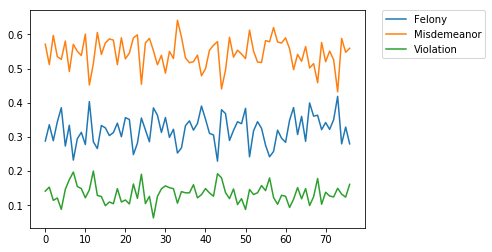

Normalized values - 


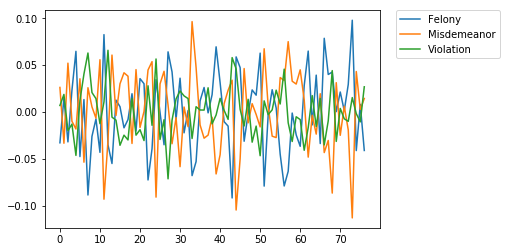

Looking only at best and worst performers - 


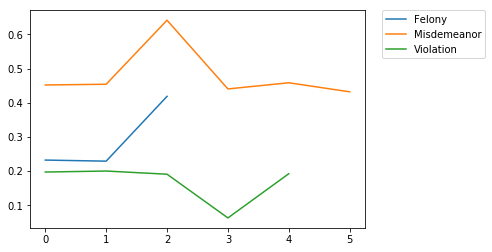

In [11]:
# NOTE 1: THIS IS THROUGH THE WHOLE DATASET, PLOTTING CRIMES AND 
# CATEGORIES OF CRIME - FELONY/MISDEMEANOR/VIOLATION ACROSS PRECINCT NUMBERS

f = []
for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="FELONY")]))
    f.append(val/tot)

m = []
for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="MISDEMEANOR")]))
    m.append(val/tot)

v = []
for i in (df["ADDR_PCT_CD"].unique()):
    tot = len(df[df["ADDR_PCT_CD"]==i])
    val = float(len(df[(df["ADDR_PCT_CD"]==i) & (df["LAW_CAT_CD"]=="VIOLATION")]))
    v.append(val/tot)

f = np.array(f)
m = np.array(m)
v = np.array(v)
print ("Absolute values for each category of crime across Categories - ")
plt.plot(np.arange(len(f)),f, label="Felony")
plt.plot(np.arange(len(m)),m, label="Misdemeanor")
plt.plot(np.arange(len(v)),v, label="Violation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print ("Normalized values - ")
plt.plot(np.arange(len(f)),f-f.mean(), label="Felony")
plt.plot(np.arange(len(m)),m-m.mean(), label="Misdemeanor")
plt.plot(np.arange(len(v)),v-v.mean(), label="Violation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

m1 = f.mean()
m2 = m.mean()
m3 = v.mean()
s1 = f.std()
s2 = m.std()
s3 = v.std()
a1,a2,a3 = [],[],[]
for i in range(len(f)):
    if f[i] > m1 + s1*2 or f[i] < m1 - s1*2:
        a1.append(f[i])
    if m[i] > m2 + s2*2 or m[i] < m2 - s2*2:
        a2.append(m[i])
    if v[i] > m3 + s3*2 or v[i] < m3 - s3*2:
        a3.append(v[i])

print ("Looking only at best and worst performers - ")
plt.plot(np.arange(len(a1)),a1, label="Felony")
plt.plot(np.arange(len(a2)),a2, label="Misdemeanor")
plt.plot(np.arange(len(a3)),a3, label="Violation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
b

Absolute values for each category of crime across Categories - 


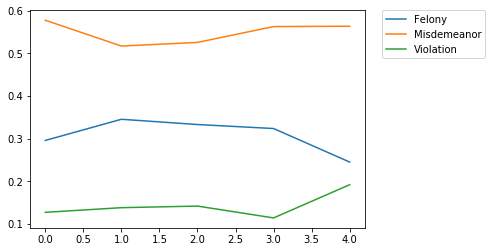

Normalized values - 


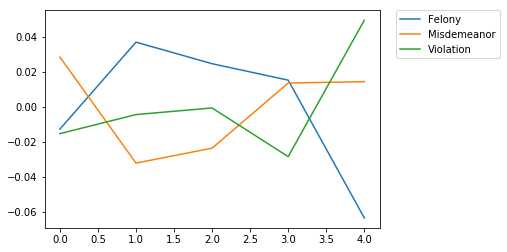

NameError: name 'l1' is not defined

In [13]:
# NOTE 1: THIS IS THROUGH THE WHOLE DATASET, PLOTTING CRIMES AND 
# CATEGORIES OF CRIME - FELONY/MISDEMEANOR/VIOLATION ACROSS PRECINCT NUMBERS

b = {}
for i in df.BORO_CAT.unique():
    b[i] = df[df["BORO_CAT"] == i]["BORO_NM"].unique()[0]
    
f = []
for i in (df["BORO_CAT"].unique()):
    tot = len(df[df["BORO_CAT"]==i])
    val = float(len(df[(df["BORO_CAT"]==i) & (df["LAW_CAT_CD"]=="FELONY")]))
    f.append(val/tot)

m = []
for i in (df["BORO_CAT"].unique()):
    tot = len(df[df["BORO_CAT"]==i])
    val = float(len(df[(df["BORO_CAT"]==i) & (df["LAW_CAT_CD"]=="MISDEMEANOR")]))
    m.append(val/tot)

v = []
for i in (df["BORO_CAT"].unique()):
    tot = len(df[df["BORO_CAT"]==i])
    val = float(len(df[(df["BORO_CAT"]==i) & (df["LAW_CAT_CD"]=="VIOLATION")]))
    v.append(val/tot)

f = np.array(f)
m = np.array(m)
v = np.array(v)
print ("Absolute values for each category of crime across Categories - ")
plt.plot(np.arange(len(f)),f, label="Felony")
plt.plot(np.arange(len(m)),m, label="Misdemeanor")
plt.plot(np.arange(len(v)),v, label="Violation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

print ("Normalized values - ")
plt.plot(np.arange(len(f)),f-f.mean(), label="Felony")
plt.plot(np.arange(len(m)),m-m.mean(), label="Misdemeanor")
plt.plot(np.arange(len(v)),v-v.mean(), label="Violation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

m1 = f.mean()
m2 = m.mean()
m3 = v.mean()
s1 = f.std()
s2 = m.std()
s3 = v.std()
a1,a2,a3 = [],[],[]
for i in range(len(l1)):
    if l1[i] > m1 + s1*2 or l1[i] < m1 - s1*2:
        a1.append(l1[i])
    if l2[i] > m2 + s2*2 or l2[i] < m2 - s2*2:
        a2.append(l2[i])
    if l3[i] > m3 + s3*2 or l3[i] < m3 - s3*2:
        a3.append(l3[i])

print ("Looking only at best and worst performers - ")
plt.plot(np.arange(len(a1)),a1, label="Felony")
plt.plot(np.arange(len(a2)),a2, label="Misdemeanor")
plt.plot(np.arange(len(a3)),a3, label="Violation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [43]:
b
for key, value in b.iteritems():
    print value
    df_tmp = df[df["BORO_NM"] == value]
    print len(df_tmp["ADDR_PCT_CD"].unique())

BRONX
12
BROOKLYN
23
MANHATTAN
22
QUEENS
16
STATEN ISLAND
4


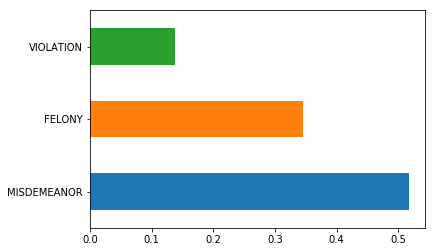

In [29]:
df_tmp = df[df['BORO_CAT'] == 3]
df_tmp = df_tmp['LAW_CAT_CD'].value_counts() / df_tmp.shape[0]
df_tmp.plot(kind='barh', stacked=True)
plt.show()

In [4]:
df.columns

Index([u'CMPLNT_FR_DT', u'CMPLNT_FR_TM', u'CMPLNT_TO_DT', u'CMPLNT_TO_TM',
       u'RPT_DT', u'KY_CD', u'OFNS_DESC', u'PD_CD', u'PD_DESC',
       u'CRM_ATPT_CPTD_CD', u'LAW_CAT_CD', u'JURIS_DESC', u'BORO_NM',
       u'ADDR_PCT_CD', u'PREM_TYP_DESC', u'Latitude', u'Longitude', u'ZIPCODE',
       u'FR_TM_CAT', u'CRM_CAT', u'LAW_CAT', u'JURIS_CAT', u'BORO_CAT',
       u'PREM_CAT', u'DATE_CAT'],
      dtype='object')

In [57]:
df_cross = pd.crosstab([df['BORO_NM'], df['LAW_CAT_CD']], df['CRM_ATPT_CPTD_CD'])
# df_cross['TOTAL'] = df_cross.sum(axis=1)
totalInNyc = df_cross.sum(axis=1).sum()
df_cross['CRIME_SUCCESS_RATE'] = df_cross['COMPLETED'] / totalInNyc

In [8]:
df_cross = pd.crosstab([df['BORO_NM'], df['LAW_CAT_CD']], df['CRM_ATPT_CPTD_CD'])
total = df_cross.sum(axis=1)
df_cross['CRIME_SUCCESS_RATE'] = df_cross['COMPLETED'] / total

In [9]:
df_cross

CRM_ATPT_CPTD_CD           ATTEMPTED  COMPLETED  SUCCESS_RATE
BORO_NM       LAW_CAT_CD                                     
BRONX         FELONY            1201      28793      0.959959
              MISDEMEANOR        372      58227      0.993652
              VIOLATION           24      12861      0.998137
BROOKLYN      FELONY            2021      50428      0.961467
              MISDEMEANOR        700      82091      0.991545
              VIOLATION           64      22252      0.997132
MANHATTAN     FELONY            1434      37566      0.963231
              MISDEMEANOR        862      66968      0.987292
              VIOLATION           55      13672      0.995993
QUEENS        FELONY            1402      35431      0.961936
              MISDEMEANOR        401      54758      0.992730
              VIOLATION           28      14683      0.998097
STATEN ISLAND FELONY             174       5467      0.969154
              MISDEMEANOR        120      12859      0.990754
              VIOLATION            9       4407      0.997962

In [58]:
df_cross

CRM_ATPT_CPTD_CD           ATTEMPTED  COMPLETED  CRIME_SUCCESS_RATE
BORO_NM       LAW_CAT_CD                                           
BRONX         FELONY            1201      28793            0.056531
              MISDEMEANOR        372      58227            0.114321
              VIOLATION           24      12861            0.025251
BROOKLYN      FELONY            2021      50428            0.099009
              MISDEMEANOR        700      82091            0.161174
              VIOLATION           64      22252            0.043689
MANHATTAN     FELONY            1434      37566            0.073756
              MISDEMEANOR        862      66968            0.131483
              VIOLATION           55      13672            0.026843
QUEENS        FELONY            1402      35431            0.069564
              MISDEMEANOR        401      54758            0.107510
              VIOLATION           28      14683            0.028828
STATEN ISLAND FELONY             174       5467            0.010734
              MISDEMEANOR        120      12859            0.025247
              VIOLATION            9       4407            0.008653

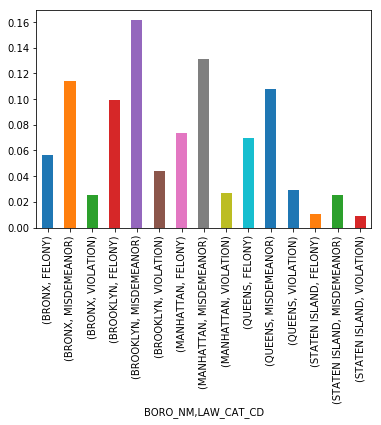

In [55]:
df_cross['SUCCESS_RATE'].plot(kind='bar')
plt.show()

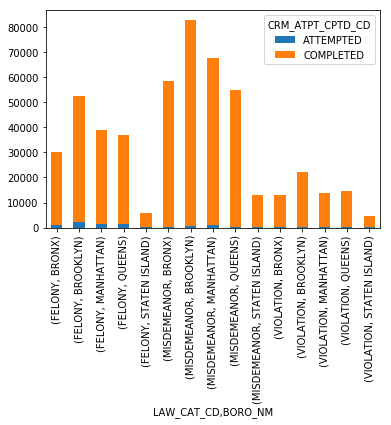

In [56]:
# multiple x-axis group by
pd.crosstab([df['LAW_CAT_CD'], df['BORO_NM']], df['CRM_ATPT_CPTD_CD']).plot(kind='bar', stacked=True)
plt.show()

In [6]:
df.groupby(['BORO_NM', 'LAW_CAT_CD'])['CRM_ATPT_CPTD_CD'].agg('count')

BORO_NM        LAW_CAT_CD 
BRONX          FELONY         29994
               MISDEMEANOR    58599
               VIOLATION      12885
BROOKLYN       FELONY         52449
               MISDEMEANOR    82791
               VIOLATION      22316
MANHATTAN      FELONY         39000
               MISDEMEANOR    67830
               VIOLATION      13727
QUEENS         FELONY         36833
               MISDEMEANOR    55159
               VIOLATION      14711
STATEN ISLAND  FELONY          5641
               MISDEMEANOR    12979
               VIOLATION       4416
Name: CRM_ATPT_CPTD_CD, dtype: int64

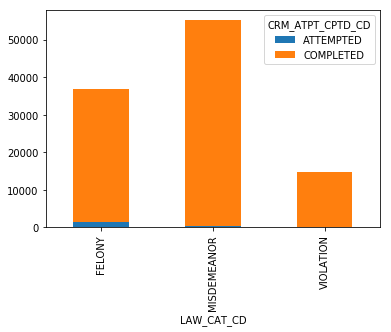

In [139]:
# multiple x-axis group by
tmp_df = df[df['BORO_NM']=='QUEENS']
pd.crosstab([tmp_df['LAW_CAT_CD']], tmp_df['CRM_ATPT_CPTD_CD']).plot(kind='bar', stacked=True)
plt.show()

In [ ]:
df.groupby('LAW_CAT_CD')['CRM_ATPT_CPTD_CD']

In [ ]:
f = df[(df['LAW_CAT_CD']=='FELONY')]['BORO_CAT'].value_counts() / df.shape[0]
print f
f = f.to_frame()
f.columns = ['CRIME_RATE']

f['BORO'] = f.index
f['BORO'] = f['BORO'].map(b)

f = f[['BORO','CRIME_RATE']]

In [12]:
b

NameError: name 'b' is not defined

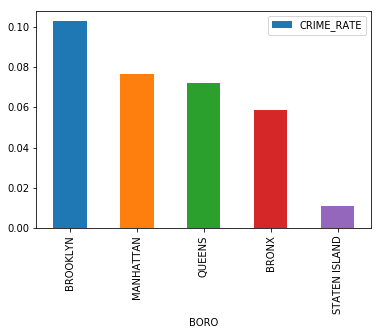

In [118]:
f.plot(kind='bar',x='BORO',y='CRIME_RATE')
plt.show()

In [105]:
b[0]

'BRONX'